# Bayesian Gaussian Mixture Model in Pyro

Trying to figure it out for myself without using autoguide.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc("text", usetex=False)
rc("font", family = "serif")
rc("figure",figsize=(9,6))
rc("figure",facecolor="white")
%config InlineBackend.figure_format = 'retina'
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from torch.nn import Parameter
from torch.distributions import constraints
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

### Generate Data for a GMM

* Specify the number of clusters `N_clusters` and the dimensionality of the data points `dims`

* Randomly initialize the means and coviariance matrices

* Sample a radndom number of points from each class from  N(mean=200,var=50)

* Randomly shuffle the data (for good measure, probably doesnt actually matter here)

In [59]:
N = 500
N_classes = 5
dims = 2

true_means = 15*torch.randn((N_classes,dims))
true_covs = torch.diag_embed(3*torch.ones(N_classes,dims)) + torch.randn(N_classes,dims,dims)
true_covs = torch.bmm(true_covs,true_covs.permute(0,2,1)) #ensure SPD-ness
true_w = torch.distributions.Dirichlet(torch.ones(N_classes)).sample()
# #N_points_per_class = (200 + 80*torch.randn(N_classes)).to(torch.int)
# #sds = torch.distributions.HalfNormal(2.5).sample(torch.Size([N_classes,2]))
# #true_chols = dist.LKJCorrCholesky(torch.tensor(dims), torch.tensor([2.5])).sample(torch.Size(N_classes)).detach()
# inds = torch.cumsum(N_points_per_class,0)
# N_points_tot = N_points_per_class.sum()
for i,w in enumerate(true_w):
    n = torch.tensor(int(w*N))
    mvn = dist.MultivariateNormal(true_means[i],covariance_matrix=true_covs[i])
    samps = mvn.sample(torch.Size([n]))
    if i==0:
        data = mvn.sample(torch.Size([n]))
        labels = torch.zeros(torch.Size([n]))
    else:
        data = torch.cat((data,samps))
        labels = torch.cat((labels, i*torch.ones(n)))
order = torch.randperm(data.shape[0])
data = data[order]
labels = labels[order]

Get a flavor of the data you just generated. If you dont like it you can always make more.

In [60]:
def draw_elliptical_contour(mu, sigma, fill=True, alpha=0.3):
    mu = mu.numpy()
    evals,evecs = sigma.symeig(eigenvectors=True)
    v = evecs[:,evals.argmax()]
    a = np.arctan2(v[1],v[0])*(180/np.pi)
    d = 2*torch.sqrt(5.991*evals)
    return Ellipse(mu, d[1], d[0], angle=a, fill=fill, alpha=alpha)

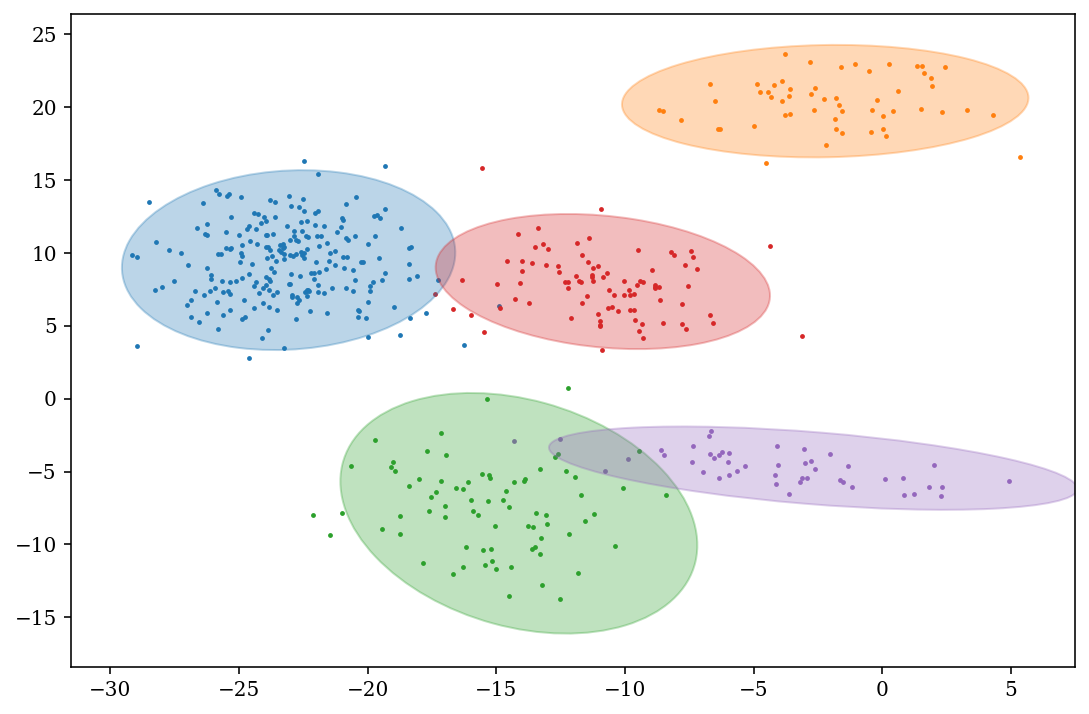

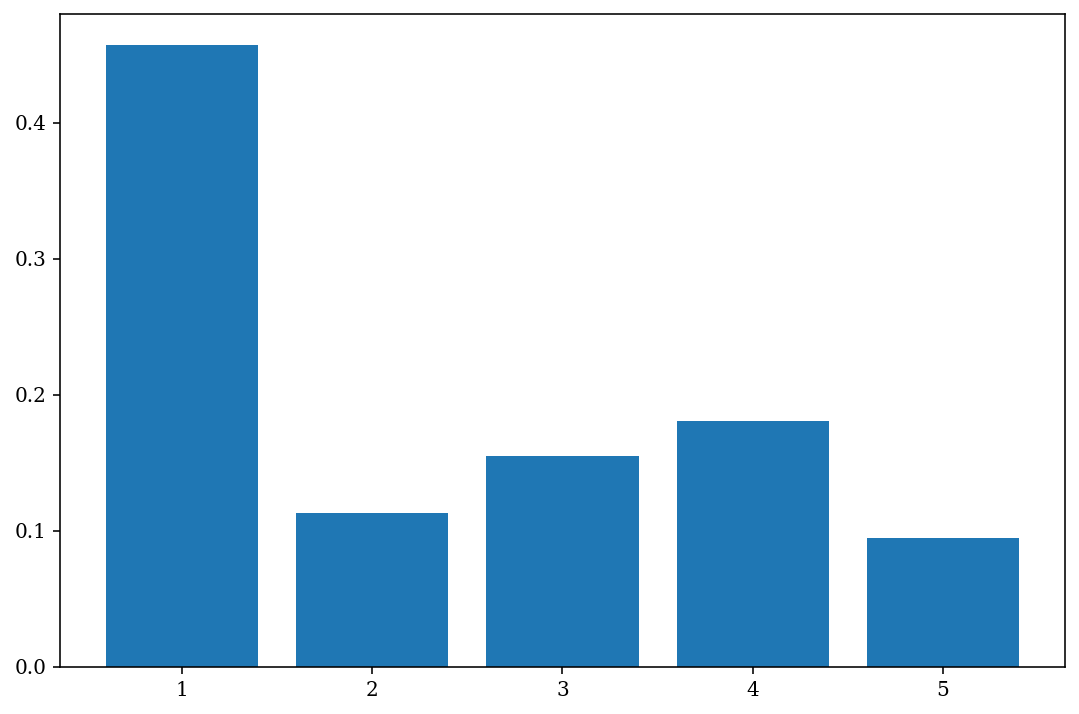

In [196]:
if dims>2:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data.numpy()[:,0], data.numpy()[:,1], data.numpy()[:, 2],c = labels.numpy())
    #ax.scatter(true_means[i,0],true_means[i,1],true_means[i,2],marker="*",s=50)
    ax.set_xlabel(r"x")
    ax.set_ylabel(r"y")
    ax.set_zlabel(r"z")
    ax.view_init(30, 50)
    plt.show()

np_labels = labels.numpy()
fig, ax = plt.subplots()
for i in range(N_classes):
    pts = data.numpy()[np_labels==i]
    ax.scatter(pts[:,0], pts[:,1], s=2)
    e = draw_elliptical_contour(true_means[i],true_covs[i])
    e.set_edgecolor(plt.get_cmap('tab10')(i))
    e.set_facecolor(plt.get_cmap('tab10')(i))
    ax.add_patch(e)
plt.show()

plt.bar(np.arange(N_classes)+1,(true_w).numpy())
plt.show()

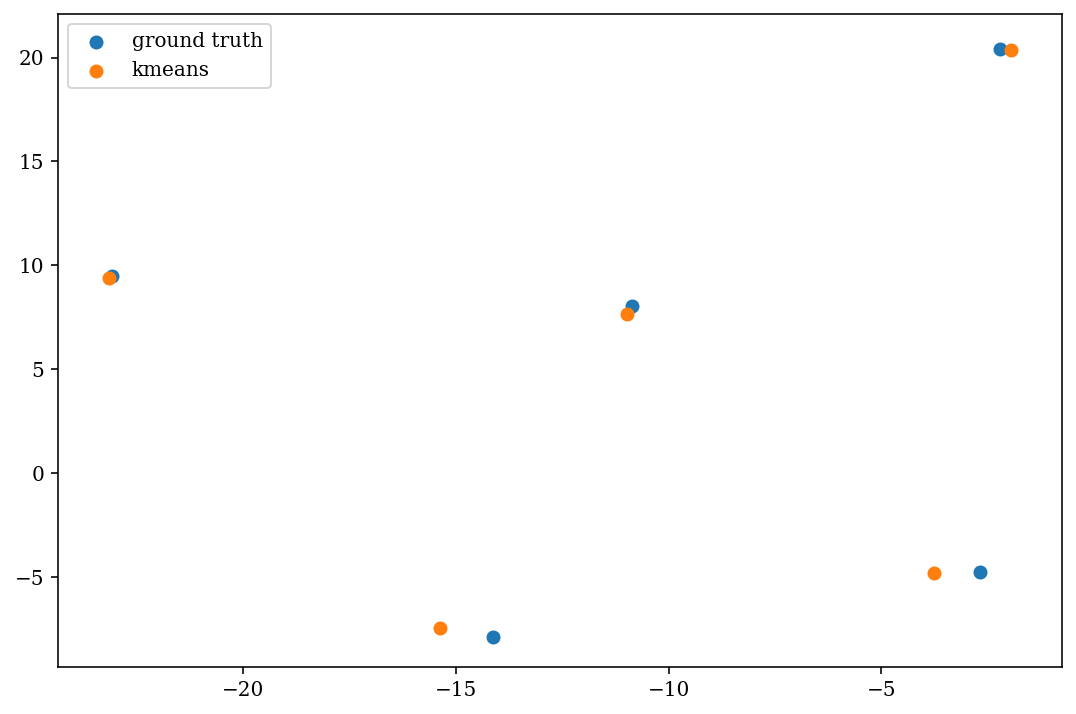

In [73]:
kmeans = KMeans(n_clusters=N_classes).fit(data.numpy())
#plt.scatter(learned_means[:,0],learned_means[:,1],label='learned')
plt.scatter(true_means[:,0].numpy(),true_means[:,1].numpy(),label='ground truth')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],label='kmeans')
plt.legend()
plt.show()

### Now lets use pyro to infer the parameters of the mixtures

In [332]:
from pyro.infer import SVI, TraceEnum_ELBO, Trace_ELBO, config_enumerate, infer_discrete
from pyro.infer import autoguide
from pyro.optim import Adam
from pyro import poutine
import warnings

In [333]:
pyro.enable_validation(True)

In [168]:
def kmeans_init(site):
    #print(site)
    kmeans = KMeans(n_clusters=N_classes).fit(data.numpy())
    if site['name']=='means':
        return torch.tensor(kmeans.cluster_centers_)
    if site['name']=='c':
        return torch.tensor(kmeans.predict(data))

In [506]:
N_classes = 5
# data = data.cuda()
@config_enumerate
def model(data):
    #misc useful quantities
    #torch.set_default_tensor_type(torch.cuda.FloatTensor)
    emp_var = torch.stack(N_classes*(data.var(0),))
    #global variable priors
    weights = pyro.sample('weights', dist.Dirichlet(10*torch.ones(N_classes)))
    
    prior_mean = torch.zeros((N_classes,2))#kmeans_init(data)
                          
    with pyro.plate("classes", N_classes):
        normal = dist.MultivariateNormal(prior_mean,covariance_matrix=torch.diag_embed(emp_var))
        
        means = pyro.sample('means', normal)
        
        gamma = dist.Gamma(.05*torch.sqrt(emp_var), 0.5*torch.ones((N_classes,dims))).to_event(1)
        scales = pyro.sample('scales',gamma)
        
        lkj_prior = dist.LKJCorrCholesky(dims,torch.tensor(1.)).expand(torch.Size([N_classes]))
        corrs = pyro.sample('corrs', lkj_prior)
    
    tril = corrs.bmm(scales.diag_embed())

        
    with pyro.plate('data',data.shape[0]) as idx:
        c = pyro.sample('c',dist.Categorical(weights)).to(torch.long)
        pyro.sample('x',dist.MultivariateNormal(means[c],scale_tril=tril[c]), obs=data[idx])
        

In [497]:
# trace = poutine.trace(model).get_trace(data)
# trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
# print(trace.format_shapes())

In [498]:
# from pyro.infer.mcmc import MCMC, NUTS
# nuts_kernel = NUTS(model)
# mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=50)
# mcmc.run(data)
# posterior_samples = mcmc.get_samples()

In [499]:
model(data)

In [507]:
pyro.clear_param_store()
guide = autoguide.AutoGuideList(model)
guide.append(autoguide.AutoDelta(poutine.block(model,expose=['corrs','weights'])))
guide.append(autoguide.AutoNormal(poutine.block(model,expose=['scales'])))
guide.append(autoguide.AutoMultivariateNormal(poutine.block(model, expose=['means']), init_loc_fn=kmeans_init))
guide.append(autoguide.AutoDiscreteParallel(poutine.block(model,expose=['c'])))

In [508]:
pyro.clear_param_store()
adam_params = {'lr':0.005, 'betas':[0.9, 0.999]}
svi = SVI(model,guide,pyro.optim.Adam(adam_params),loss = TraceEnum_ELBO() )

In [509]:
losses = []
for i in range(2500):
    losses.append(svi.step(data))
    if (i+1)%100==0:
        print(f'Step {i+1} -- Loss = {losses[-1]}', end = '\r')

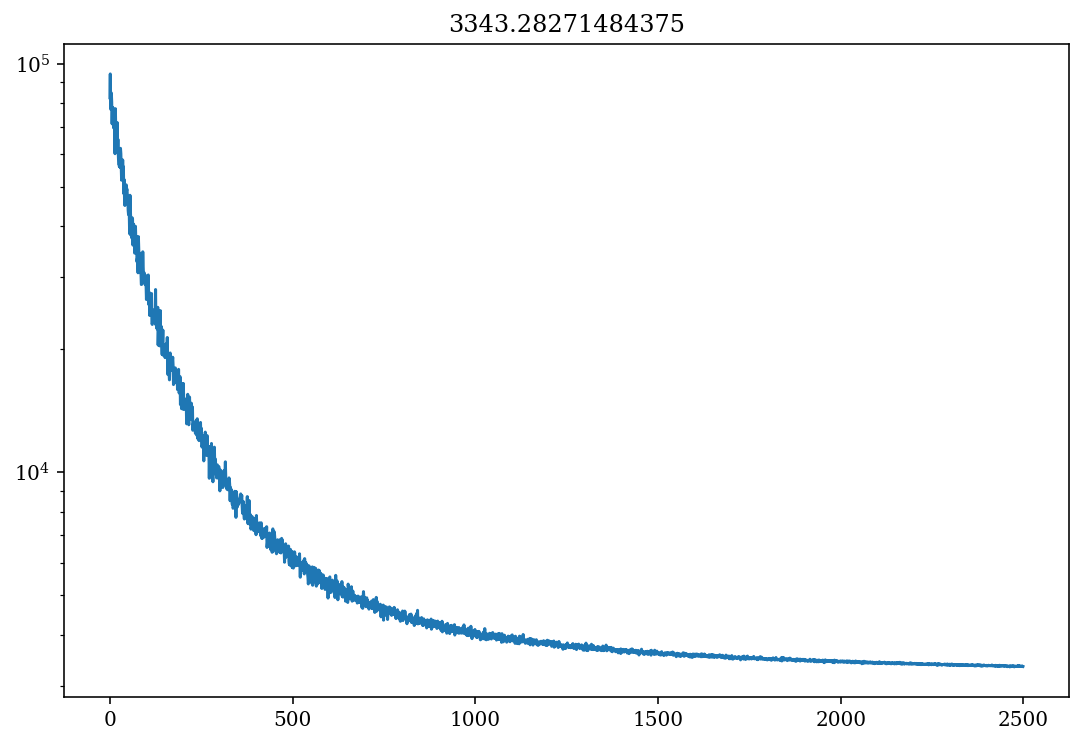

In [510]:
plt.plot(losses)
plt.title(losses[-1])
plt.semilogy()
plt.show()

In [511]:
map_estimate = guide(data)
map_means = map_estimate['means'].detach()
map_scales = map_estimate['scales']
map_corrs = map_estimate['corrs']
map_tril = map_corrs.bmm(map_scales.diag_embed()).detach()
map_cov = map_tril.bmm(map_tril.permute(0,2,1))
map_c = map_estimate['c'].detach().numpy()
map_w = map_estimate['weights'].detach().numpy()

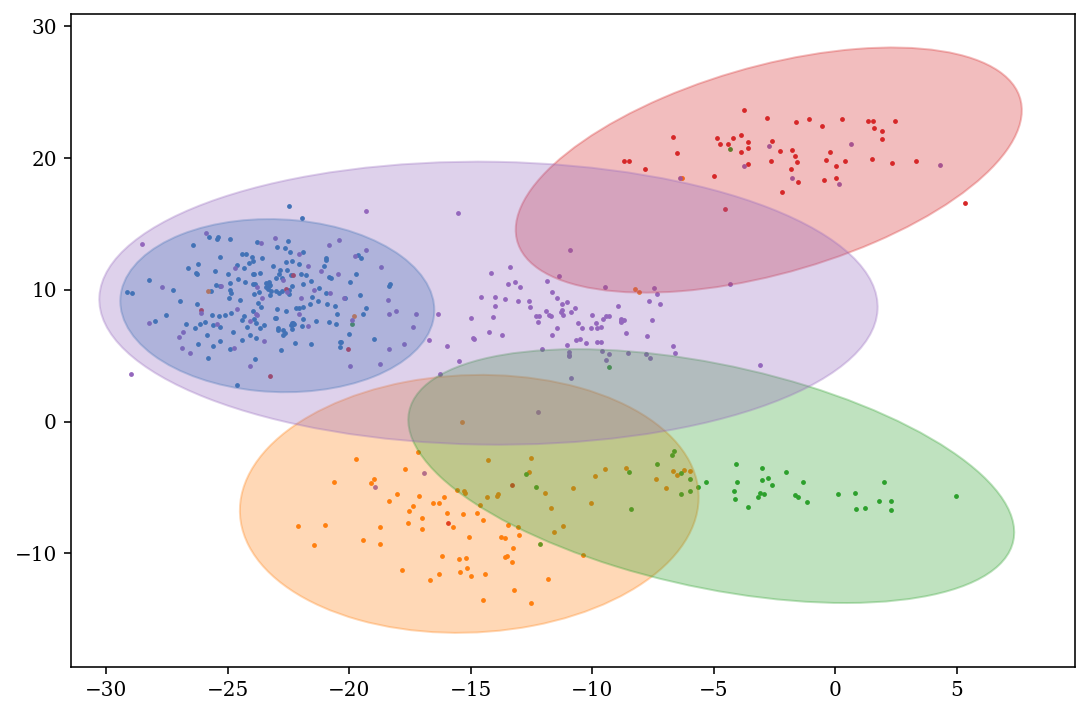

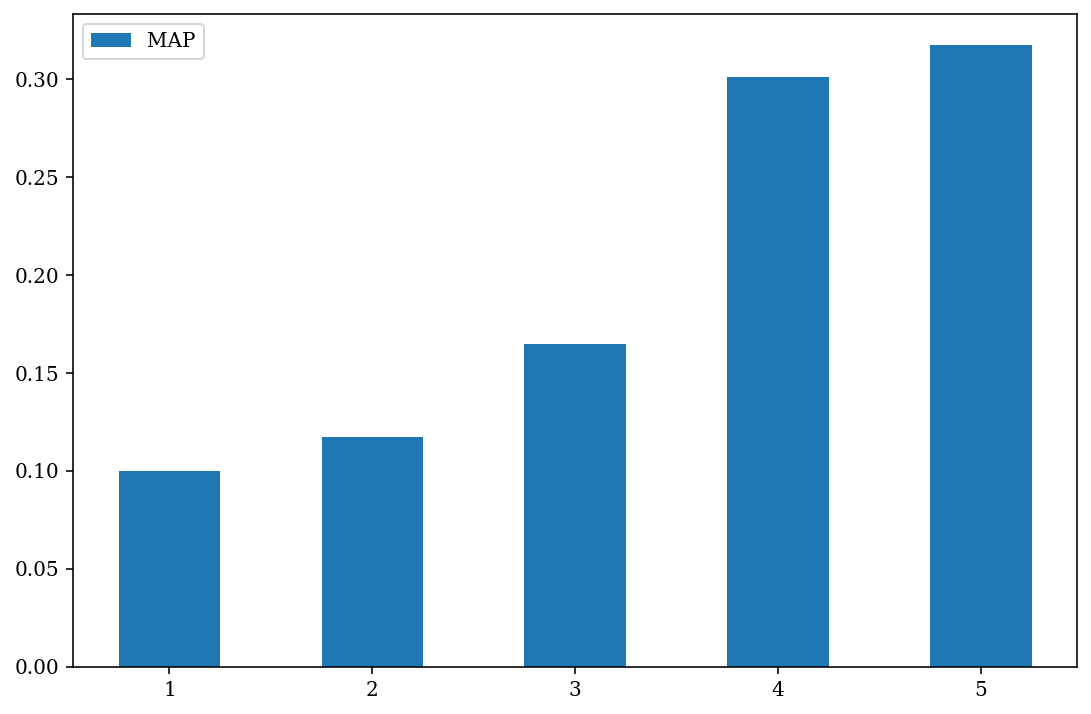

In [512]:
fig, ax = plt.subplots()
for i in range(N_classes):
    pts = data.numpy()[map_c==i]
    if pts.shape[0]>0:
        ax.scatter(pts[:,0], pts[:,1], s=2)
        if map_w[i]>0.05:
            e = draw_elliptical_contour(map_means[i],map_cov[i])
            e.set_edgecolor(plt.get_cmap('tab10')(i))
            e.set_facecolor(plt.get_cmap('tab10')(i))
            ax.add_patch(e)
plt.show()

#plt.bar(np.arange(N_classes)+1.25, np.sort((true_w).numpy()),width=0.5, label="True")
plt.bar(np.arange(N_classes)+1, np.sort((map_estimate['weights'].detach().numpy())), width=0.5,label='MAP')
plt.legend()
plt.show()

### Concluding thoughts

Generally feel good about this model and performance in pyro. Learned a lot by getting this up and running again.

I spent a long time trying to get this to work as a "dirichlet process" by increasing the number of components and seeing which ones ended up with appreciable (>0.05) weight in the end. Turns out the DP model is hard to fit. The $\alpha$ parameter for the DP prior is super important. It helps not to use k-means initilization once you go to more components since you end up with a bunch of components in the same place. 

- It could be the case that doing VI is actually better with the stick breaking construction though I dont really understand why.
- Generally it seems that you need to really know what kind of solution you are looking for and have a very realistic practice/synthetic dataset to try it out on.
- I didnt try to learn a good value of alpha for the Dirichlet distribution. Maybe I was limiting mysely by using $\alpha \times \bf{1}$ for the prior. And then learning the weights rather than learnign the alpha vector. 

It would be interesting if there were a reasonable prior for dispersion -- like some Lennard-Jones thing -- for the centers of the components. Would be reasonable to set the lengthscale for this given the empirical variance.

Could be interesting at some point to compute the Cross entropy loss of the predictions just to see how its doing as a classifier. (N.B. you can still get the variational parameters from the param store but the naming is kind of funky due to the AutoGuideL

Also I never made this work (well at least) with MCMC. I did it in PyMC3 once so I belive I could do it in pyro if I really wanted just need to collapse the mixture model (i.e. marginalize the assigments)

If I ever use this again I need to wrap it into a class that inherits `nn.Module`

Below here is just scratch work including an attempt to make a custom guide for this problem. My current view is that its more trouble than its worth given the realtive ease of autoguide but it seems to mostly work. 

In [514]:
#OK so I accidentally deleted this cell after I had it working but got a slightly old version from github.
#If you want to use this make the parameters better match the priors from the model

def custom_guide(data):
    #variational params
    alpha = pyro.param('alpha',torch.ones(N_classes),constraint=constraints.positive)

    m_loc = pyro.param('m_loc',torch.tensor(kmeans.cluster_centers_))
    m_scale = pyro.param('m_scale',20*torch.stack(N_classes*(torch.eye(dims),)) ,constraint=constraints.lower_cholesky)
    
    var_conc = pyro.param('v_shape',5*torch.ones((N_classes,dims)), constraint=constraints.positive)
    var_rate = pyro.param('v_rate', torch.ones((N_classes,dims)) ,constraint=constraints.positive)
    cc = pyro.param('cc', torch.ones((N_classes,dims)).diag_embed(), constraint=dist.lkj.corr_cholesky_constraint)
    
    phi = pyro.param('phi',torch.stack(data.shape[0]*(torch.ones(N_classes)/N_classes,)),constraint=constraints.simplex)
    
    #global latent vars
    weights = pyro.sample('weights', dist.Dirichlet(alpha))
    
    #model latent vars
    with pyro.plate('classes',N_classes):
        means = pyro.sample('means',dist.MultivariateNormal(m_loc,scale_tril=m_scale))
        
        gamma = dist.Gamma(var_conc, var_rate).to_event(1)
        #print("guide", gamma.event_shape)
        scales = pyro.sample('scales',gamma)
        
        delta = dist.Delta(cc,event_dim=2)

        corrs = pyro.sample('corrs', delta) #do MAP inference bc no broadcasting for lkj

        
    with pyro.plate('data', data.shape[0]):
        c = pyro.sample('c',dist.Categorical(phi),infer={"enumerate": "parallel"})

In [513]:
adam_params = {"lr": 0.005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=1), num_samples=1000)

In [311]:
losses = []
for i in range(2500):
    losses.append(svi.step(data))
    if (i+1)%100==0:
        print(f'Step {i+1} -- Loss = {losses[-1]}', end = '\r')

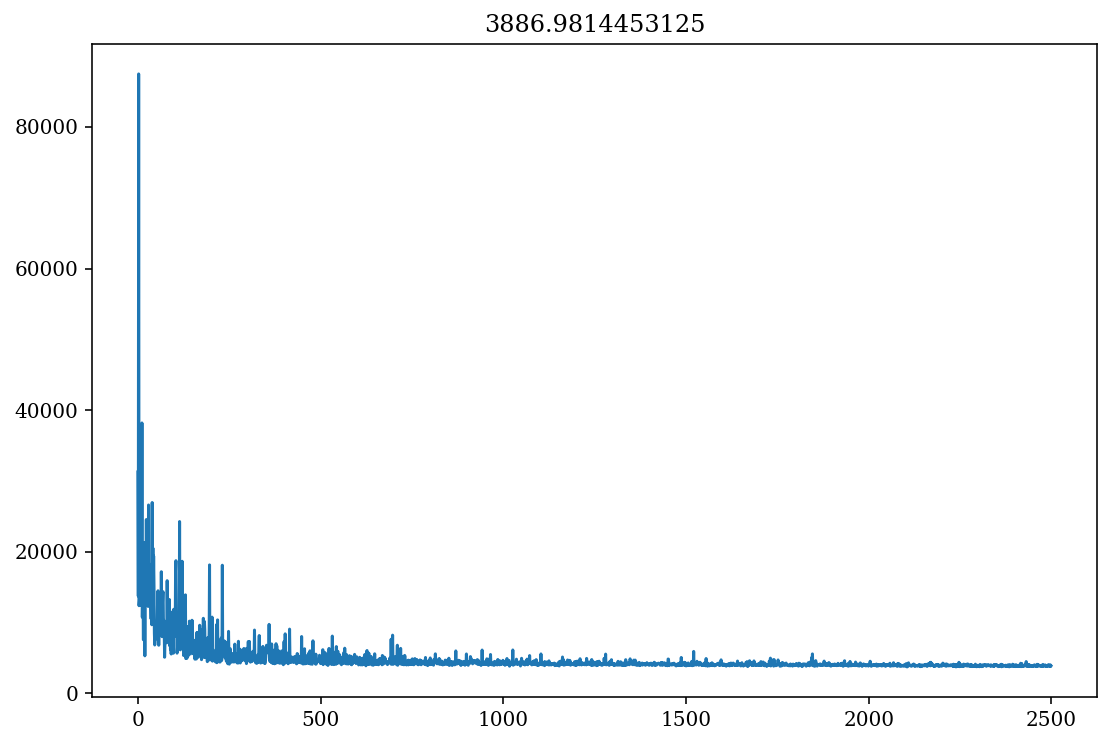

In [312]:
plt.plot(losses)
plt.title(losses[-1])
plt.show()

In [190]:
learned_means = pyro.param('m_loc').detach().numpy()
learned_probs = pyro.param('phi').detach().numpy()
learned_scales = pyro.param('m_scale').detach().numpy()

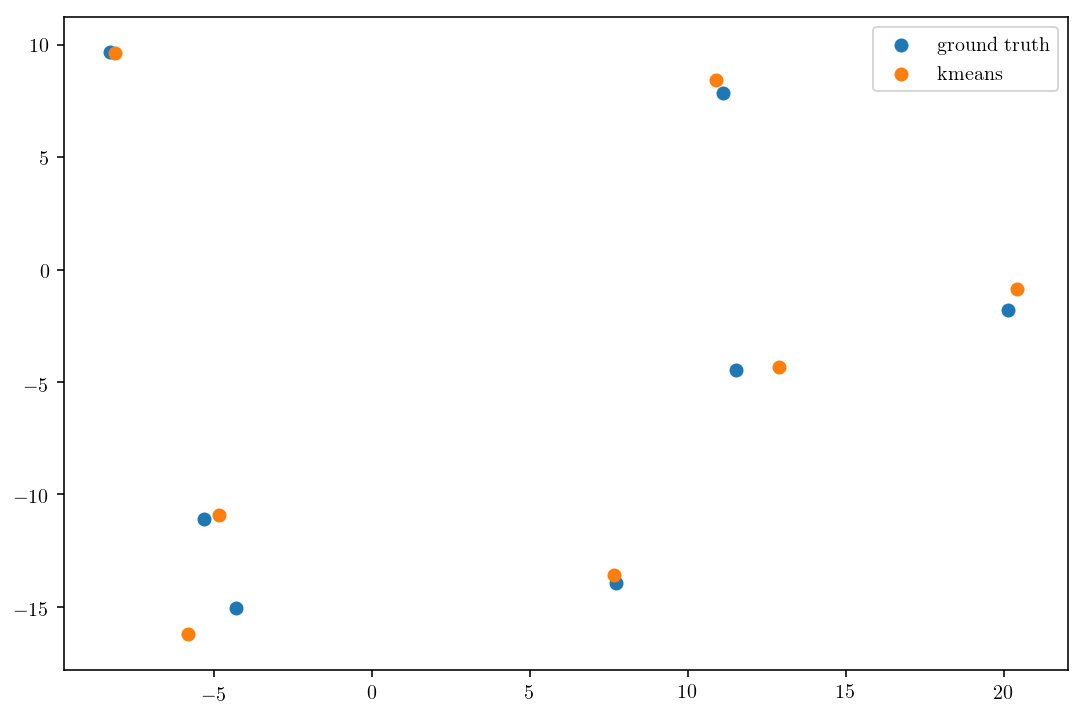

In [135]:
#plt.scatter(learned_means[:,0],learned_means[:,1],label='learned')
plt.scatter(true_means[:,0].numpy(),true_means[:,1].numpy(),label='ground truth')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],label='kmeans')
plt.legend()
plt.show()

In [137]:
from pyro.infer.mcmc import NUTS, MCMC

In [141]:
pyro.clear_param_store()
nuts_kernel = NUTS(model, adapt_step_size=True,jit_compile=True)
hmc_posterior = MCMC(nuts_kernel,200)
#hmc_posterior.run(data)

In [29]:
from matplotlib.patches import Ellipse

In [95]:
Sigma = torch.tensor([[2,1.1],[1.1,3]])
mu = true_means[1]
mvn = torch.distributions.MultivariateNormal(loc=mu,covariance_matrix=Sigma)
samples = mvn.sample(torch.Size([500])).numpy()

In [96]:
evals,evecs = Sigma.symeig(eigenvectors=True)

In [98]:
v = evecs[:,evals.argmax()]
a = np.arctan2(v[1],v[0])*(180/np.pi)

In [105]:
d = 2*torch.sqrt(5.991*evals)

In [106]:
cr = Ellipse(mu, d[1], d[0], angle=a, fill=False)

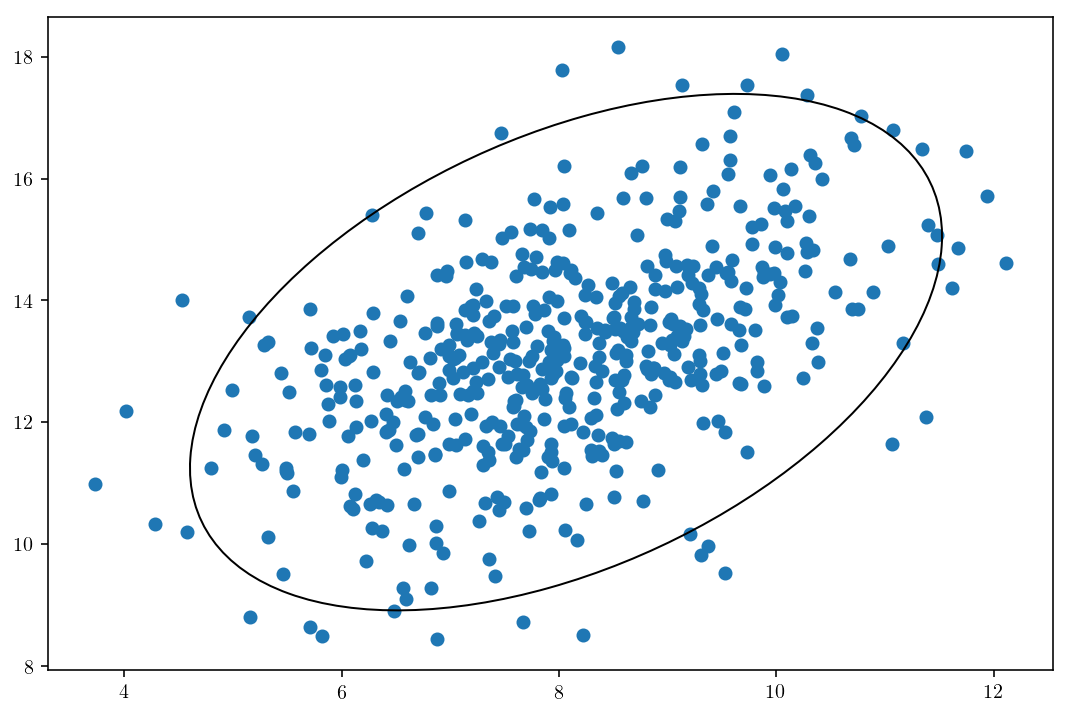

In [107]:
fig, ax = plt.subplots()
ax.scatter(samples[:,0],samples[:,1])
ax.add_patch(cr)
plt.show()

In [258]:
emp_var = data.var(0)

In [272]:
pts = dist.Gamma(.5*torch.sqrt(emp_var[0]),.5).log_prob(torch.linspace(0.1,50,200)).exp().numpy()

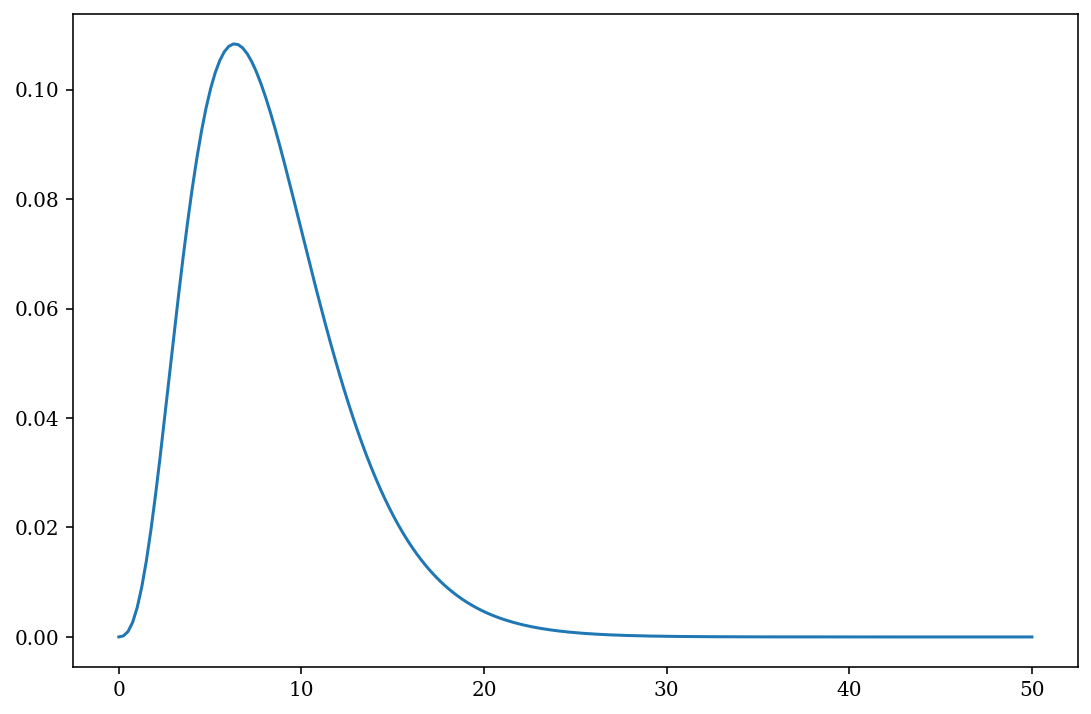

In [273]:
plt.plot(np.linspace(0,50,200), pts)
plt.show()

In [263]:
true_covs

tensor([[[ 7.0041,  0.5593],
         [ 0.5593,  6.3559]],

        [[10.4103,  0.2922],
         [ 0.2922,  2.4858]],

        [[ 8.0281, -2.5355],
         [-2.5355, 11.3716]],

        [[ 7.0446, -1.0479],
         [-1.0479,  3.5865]],

        [[17.5983, -2.4241],
         [-2.4241,  1.3644]]])

In [ ]:
#Used to make nice plots of the simulated data but i changed the data generation procedure.
if dims>2:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i in range(N_classes):
        ax.scatter(data[i,:,0], data[i,:,1], data[i,:, 2])
        ax.scatter(true_means[i,0],true_means[i,1],true_means[i,2],marker="*",s=50)
    ax.set_xlabel(r"x")
    ax.set_ylabel(r"y")
    ax.set_zlabel(r"z")
    ax.view_init(30, 50)
    plt.show()

r = ['x','x','z']
d1,d2 = 0,1
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(N_classes):
    ax.scatter(data[i,:,d1], data[i,:,d2])
    ax.scatter(true_means[i,d1], true_means[i,d2],marker="*",s=50)
ax.set_xlabel(r"{}".format(r[d1]))
ax.set_ylabel(r"{}".format(r[d2]))
#ax.set_zlabel(r"z")
#plt.title(r"True means",fontsize=16)
plt.show()